# Assignment 1: Graph Pathfinding with Genetic Algorithms

In [1]:
import pygad
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

## Task 1: Shortest path between 2 nodes

Here we are creating a few graphs that will serve as examples. Graph are represented like this: first a specified number of nodes and the list of connections (*Node A*, *Node B*, *Distance*).   
The goal of the first task is to find the shortest distances between two nodes. In addition to the graph itself, the input data should also include the start and end nodes.   
Choose and implement a suitable fitness function and run a genetic algorithm to find the shortest path in a given graph provided as a .txt file.   
Experiment with different mutation/crossover functions and other GA parameters(population size, selection, etc.) and try to find the optimal configuration of the algorithm.

In [17]:
# save graph
with open("graphs/g5.txt") as f: n = int(f.readline())
print(n)

graph = pd.read_csv("graphs/g5.txt", sep=" ", skiprows=1, names=["A", "B", "w"])
print(graph)

3
   A  B  w
0  1  2  1
1  2  3  1
2  3  1  1


In [101]:
start = 1
end = 3

# gene space so nodes grafa, a brez start in end - dodala 0, za direktne povezave
gene_space = [i for i in range(0, n+1) if i != start and i != end]
print(gene_space)

[0, 2]


In [102]:
INVALID = -1e12

def pathLength(pygad_instance, path, solution_index):
#def length(path):
    path_real = []
    seen = set()

    for x in path:
        if x != 0 and x not in seen:
            path_real.append(x)
            seen.add(x)
    path_real.append(end)

    N = len(path_real)
    dist = 0
    prev = start

    for i in range(N): 
        node = path_real[i]

        w = graph.loc[(graph['A'] == prev) & (graph['B'] == node), 'w']
        if w.empty:
            return INVALID    # punish not available path
        
        dist += w.values[0]
        prev = node

    return -dist

#length([3])  # bi pomenilo pot 1->3->4

In [103]:
ga_instance = pygad.GA(fitness_func = pathLength,
                       num_generations=100,    #<- kasneje za probat
                       num_parents_mating=10,
                       sol_per_pop=50,
                       num_genes=(n-2), # fixed length 
                       gene_space=gene_space,
                       gene_type=int,
                      )

ga_instance.run()

In [105]:
#solution, solution_fitness, solution_idx = ga_instance.best_solution()
#print(-solution_fitness)
ga_instance.best_solution()

(array([2]), np.float64(-2.0), np.int64(0))

In [ ]:
ga_instance.plot_fitness()

## Task 2: Shortest path between multiple nodes    
The goal of the second task is to update the GA from Task 1 with the ability to follow a path consisting of multiple nodes. Your GA should receive a sequence of N target nodes A, B, C,...N and return the shortest path that follows the given node order. Paths that do not visit every target node or paths that visit the target nodes in the incorrect order are no longer valid.    
Note that your solutions may now need to visit a single node multiple times (for example, to backtrack through a graph)    
In addition, improve your GA using crossover and mutation functions. Since the task now contains strict requirements you can implement those constraints into crossover and mutation functions and into starting population.

In [93]:
# target sequence
sequence = [1,3,2]

In [94]:
# here i changes that numer of genes = n, so the start and end nodes are included in fitness function

def pathLength_multipleNodes(pygad_instance, path, solution_index):
    # Calculate path length
    it = 0
    dist = 0

    for i in range(len(path)-1): 
        node1, node2 = path[i], path[i+1]
        if(node1 == node2 or node1 == 0): continue

        w = graph.loc[(graph['A'] == node1) & (graph['B'] == node2), 'w']
        if w.empty:
            return INVALID
        
        dist += w.values[0]

        if(node1 == sequence[it]): it += 1
        if(it == len(sequence)): return -dist

    if(path[-1] == sequence[it]): return -dist
    return INVALID


In [95]:
# intial population with constraints
def creating_init_pop(k):
    genom_len = k*n
    pop = []

    for _ in range(50):   # v oklepaju solutions per population
        # all the nodes we can add
        full_gene_space = [node for node in range(0, n+1)]
        number_of_nodes_to_insert = genom_len - len(sequence)      # je odvisno od num_genes

        # we decide on which indices we will insert random nodes into original sequence
        # we cannot insert them in [0] and [n-1] position (start and end)

        # list of indices on which we are going to insert new nodes
        positions = []

        # list of indices we can choose from
        possible_indices = list(range(genom_len))

        for _ in range(number_of_nodes_to_insert):
            # random choice of possible indices
            idx = np.random.choice(possible_indices)
            # we remove it from options
            possible_indices.remove(idx)
            # add to positions
            positions.append(idx)
        
        # all thats left is to build our startion population 
        # in indices from position we put a random node from full gene space

        # building process :)
        pop_individual = [-1] * genom_len   # list of n elements with value -1

        for x in positions:
            pop_individual[x] = np.random.choice(full_gene_space)
        
        it = 0
        for i in range(genom_len):
            if pop_individual[i] == -1:
                pop_individual[i] = sequence[it]
                it += 1

        # moja logika pravi, da bi moglu bit ok
        pop_individual = np.array(pop_individual)
        pop.append(pop_individual)
    
    print(pop)
    return pop


In [96]:
# crossover function with those constraints

def custom_crossover(parents, offspring_size, ga_instance):
    offspring = []

    # offspring_size is a touple of 2 numbers: (the offspring size, number of genes)
    size_of_offspring, number_of_genes = offspring_size

    parents_size = len(parents)

    for i in range(size_of_offspring):
        # randomly choose 2 parents
        parent_indices = np.random.choice(parents_size, 2, replace=False)
        parent1 = parents[parent_indices[0]]
        parent2 = parents[parent_indices[1]]

        # now we have two random parents we chose for mating
    
        # idea: we traverse both parents and save possible points for crossovers
        # then we randomly select a point for crossover from the available points

        available_points_for_crossover = []

        # iterating over sequence
        it1 = 1
        it2 = 1

        for pos in range(1, number_of_genes-1):
            if it1 == it2:
                available_points_for_crossover.append(pos)
            if it1 < len(sequence) - 1 and parent1[pos] == sequence[it1]:
                it1 += 1
            if it2 < len(sequence) - 1 and parent2[pos] == sequence[it2]:
                it2 += 1
        
        chosen_crossover_point = np.random.choice(available_points_for_crossover, 1, replace=False)

        # combine parents to get child
        individual_offspring = np.concatenate([parent1[:chosen_crossover_point[0]], parent2[chosen_crossover_point[0]:]])

        offspring.append(individual_offspring)


    return np.array(offspring)

In [97]:
# mutation function with the same constraints
def custom_mutation(offspring, ga_instance):
    # after crossover, the offspring is handed to mutation
    
    # idea: swap two genes - not if they are both in sequence

    for offspring_individual in offspring:

        length = len(offspring_individual)

        swap_points = []
        it = 1


        for i in range(1, length-2):

            if offspring_individual[i] not in sequence[1:-1]:
                swap_points.append(i)

            if it < len(sequence) - 1 and offspring_individual[i] == sequence[it]:
                it += 1       

        if swap_points:
            chosen_swap_point = np.random.choice(swap_points)
            offspring_individual[chosen_swap_point], offspring_individual[chosen_swap_point+1] = offspring_individual[chosen_swap_point+1], offspring_individual[chosen_swap_point]      

    return offspring

In [98]:
# creating a new population everytime i run GA
k = 2
init_pop = creating_init_pop(k)
print(init_pop)

ga_instance = pygad.GA(fitness_func=pathLength_multipleNodes,
                       num_generations=200,
                       num_parents_mating=5,
                       initial_population=init_pop,
                       sol_per_pop=50,
                       num_genes=(n*k), # tried with n
                       gene_space=gene_space,
                       gene_type=int,
                       crossover_type=custom_crossover,
                       mutation_type=custom_mutation,
                      )

ga_instance.run()

[array([1, 2, 3, 2, 3, 0]), array([2, 1, 1, 3, 2, 3]), array([3, 1, 1, 1, 3, 2]), array([1, 3, 2, 0, 3, 1]), array([1, 3, 1, 3, 2, 0]), array([2, 2, 1, 3, 2, 1]), array([1, 3, 2, 0, 1, 0]), array([1, 1, 2, 3, 2, 3]), array([0, 1, 1, 3, 3, 2]), array([1, 3, 0, 1, 3, 2]), array([3, 1, 1, 2, 3, 2]), array([3, 1, 3, 3, 0, 2]), array([1, 2, 3, 0, 3, 2]), array([0, 1, 3, 3, 0, 2]), array([1, 1, 3, 3, 2, 1]), array([1, 3, 2, 3, 1, 2]), array([0, 3, 1, 3, 3, 2]), array([1, 3, 0, 3, 3, 2]), array([1, 3, 2, 0, 3, 3]), array([1, 1, 2, 3, 2, 0]), array([1, 3, 0, 2, 2, 2]), array([1, 1, 3, 2, 2, 3]), array([2, 1, 2, 0, 3, 2]), array([1, 3, 2, 3, 2, 0]), array([2, 1, 2, 3, 2, 3]), array([0, 1, 3, 2, 0, 1]), array([1, 3, 3, 0, 0, 2]), array([0, 2, 1, 3, 2, 2]), array([1, 0, 1, 3, 3, 2]), array([3, 1, 3, 3, 2, 0]), array([1, 2, 3, 2, 2, 3]), array([2, 1, 3, 2, 0, 2]), array([1, 3, 3, 1, 2, 0]), array([2, 1, 1, 1, 3, 2]), array([2, 3, 1, 1, 3, 2]), array([0, 1, 1, 3, 2, 2]), array([1, 1, 0, 3, 1, 2]), 

c:\Python312\Lib\site-packages\pygad\pygad.py:733: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(


In [99]:
ga_instance.best_solution()

(array([0, 3, 1, 2, 2, 3]), np.float64(-1000000000000.0), np.int64(0))

c:\Python312\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


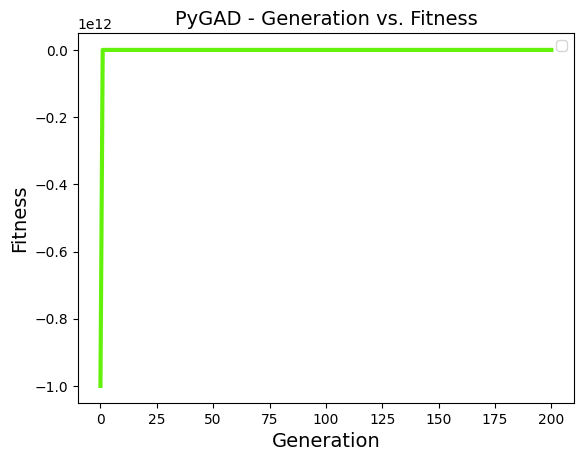

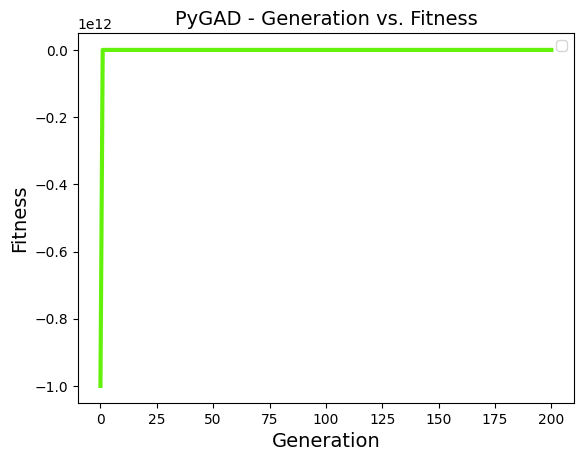

In [100]:
ga_instance.plot_fitness()

# Task 3